# [3] Volume Rendering

아래 식은 NeRF 논문에서 광선(ray)을 따라 **볼륨 렌더링**을 수행할 때, 각 샘플 지점에서 얻은 색(color)과 밀도(density)를 이용해 최종 픽셀 색을 합산하는 공식입니다.  

$$
\hat{C}({r}) \;=\; \sum_{i=1}^N \; T_i \,\bigl(1 - \exp(-\sigma_i \,\delta_i)\bigr)\;\mathbf{c}_i  
\quad \text{where}\quad
T_i \;=\; \exp\!\Bigl(-\sum_{j=1}^{i-1}\sigma_j\,\delta_j\Bigr).
$$

여기서:

1. $\mathbf{r}$: 광선(ray)의 파라미터.  
2. $i=1\ldots N$: 광선을 따라 샘플링한 점들의 인덱스.  
3. $\sigma_i$: i번째 점의 **밀도(density)**.  
4. $\mathbf{c}_i$: i번째 점의 **색(color)**.  
5. $\delta_i$: i번째 샘플과 이전 샘플 사이의 거리. (두께로 생각할 수 있음)  
6. $T_i$: i번째 샘플까지 도달하기 전까지의 “누적 투명도”.  



## 1. $\alpha_i = \bigl(1 - \exp(-\sigma_i \delta_i)\bigr)$

- 광선이 두께가 $\delta_i$, 밀도가 $\sigma_i$인 지점 i를 지나면서 불투명이 발생한다.
- 즉, $\alpha_i$는 **i번째 샘플 구간**(밀도 $\sigma_i$, 두께 $\delta_i$)에서 빛이 차단(또는 흡수)되는 비율입니다.
- 이 값은 0~1 사이이며, 구간이 짧거나($\delta_i$ 작음) 밀도가 낮으면($\sigma_i$ 작음) → $\alpha_i\approx 0$.

$$
\alpha_i = 1 - e^{-\sigma_i \,\delta_i}.
$$

- 여기에 $\sigma_i \delta_i$를 하나의 변수 $x$라고 놓으면,  
  $$
    \alpha_i = 1 - e^{-x}.
  $$

### 그래프 $y = 1 - e^{-x}$ 특징
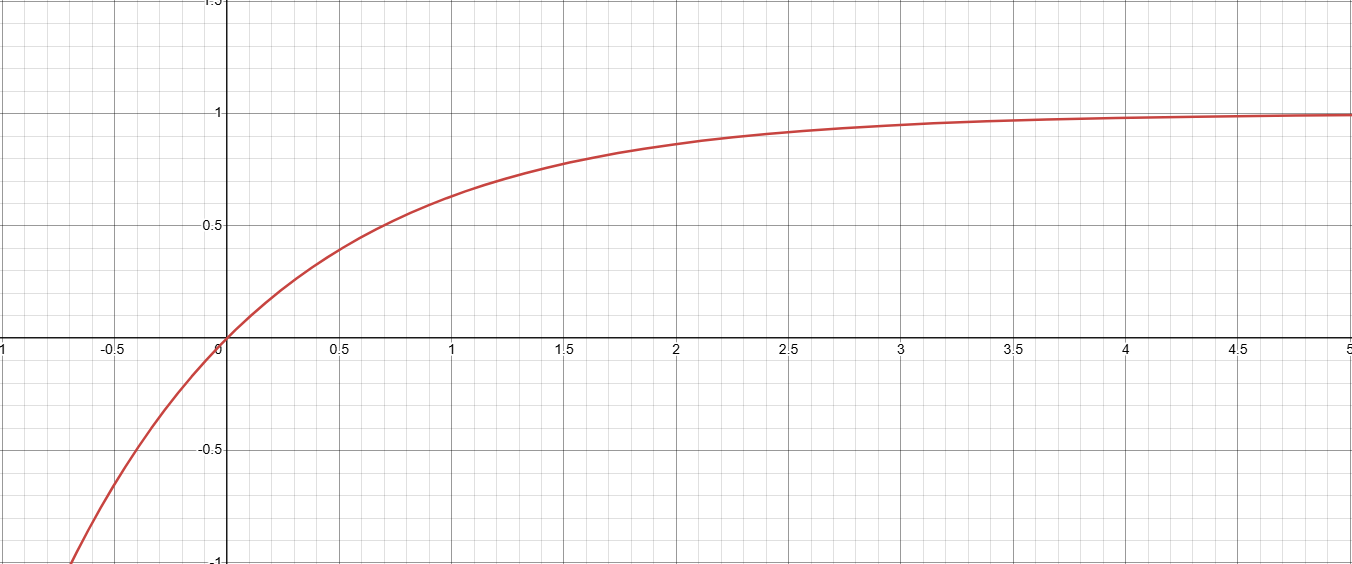
1. $x=0$일 때 $y=0$. (즉, 구간 길이와 밀도가 0이면 흡수도 0)
2. $x \to \infty$일 때 $e^{-x}\to 0$, 따라서 $y\to 1$. (밀도$\times$두께가 매우 크면 구간을 완전히 불투명하게 가림)
3. 단조 증가: $x$가 커질수록 $y$가 0→1 사이를 늘려가며 증가.  

이를 통해  
- 작은 구간($\delta_i$ 작거나 $\sigma_i$ 작을 때) → “거의 투과 ($\alpha\approx 0$)”  
- 구간이 클수록(또는 밀도가 크면) → “$\alpha$가 1에 가까워져 더 많이 빛을 차단”  
이라는 물리적 직관을 얻을 수 있습니다.


## 2. $T_i = \exp\!\Bigl(-\sum_{j=1}^{i-1}\sigma_j\,\delta_j\Bigr)$

- i번째 지점 전까지, 광선이 지나온 모든 구간 $j=1\ldots i-1$에서의 밀도 $\sigma_j$와 두께 $\delta_j$를 합산한 것.
- 즉, **이전까지 빛이 흡수된 비율의 총합**
- 만약 앞 구간들의 밀도 합이 크면, $T_i$가 작아져서 현재 샘플의 값이 거의 반영되지 않습니다.
$$
T_i = \exp\bigl(-\underbrace{\sum_{j=1}^{i-1} \sigma_j\,\delta_j}_{x}\bigr).
$$

- 여기서 $\sum_{j=1}^{i-1} \sigma_j\,\delta_j$를 하나의 변수 $x$라 두면,

$$
T_i = e^{-x}.
$$

### 그래프 $y = e^{-x}$ 특징
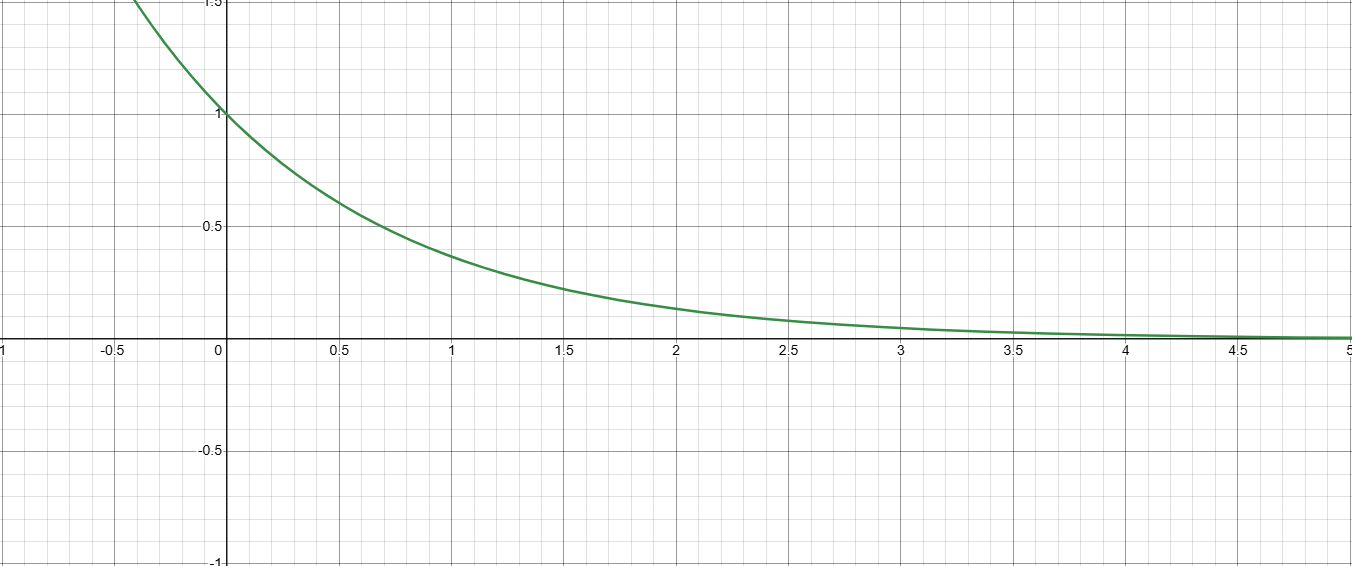
1. $x=0$ → $y=1$. (지금까지 빛의 흡수가 전혀 없었다면, 가중치가 1)  
2. $x\to \infty$ → $y\to 0$. (앞에서 이미 많은 흡수가 일어났다면, 현재 시점의 가중치가 0에 가까움)  
3. **단조 감소**: $x$가 커질수록 $e^{-x}$는 1→0 범위로 줄어든다.

위 그래프의 특징을 바탕으로 $T_i$를 이해해보면,  
- 앞쪽에 빛을 가리는 물체가 없으면 → $T_i \approx 1$ 
- 앞에서 빛을 가리는 물체가 있으면 → $T_i \approx 0$

## 3. 식 전체: $\hat{C}(\mathbf{r}) = \sum_{i=1}^N T_i \,\alpha_i \,\mathbf{c}_i$

- **i번째 샘플의 기여도** = “이 지점까지 도달한 빛의 비율($T_i$) × 이 지점에서 새로 흡수되는 비율($\alpha_i$)” × “색($\mathbf{c}_i$)”.
- 모든 샘플을 합산하면 최종 픽셀 색($\hat{C}$).
- **NeRF**는 MLP로부터 학습 가능한 파라미터인 $\sigma_i,\mathbf{c}_i$를 추론해 이 식을 계산함으로써, 특정 위치를 바라보는 카메라의 각 픽셀 색상을 결정할 수 있게 됩니다.

In [1]:
import torch
import torch.nn.functional as F

def raw2outputs(
    raw,            # shape: (N_rays, N_samples, 4)  -> [R, G, B, density] (모델의 output)
    z_vals,         # shape: (N_rays, N_samples)     -> 샘플 포인트들까지의 깊이(혹은 t값)
    rays_d,         # shape: (N_rays, 3)             -> 각 광선의 방향 벡터
    raw_noise_std=0,# density에 추가할 노이즈 크기
    white_bkgd=False,
):
    """
    NeRF의 볼륨 렌더링 공식에 따라, (R,G,B,density) -> 각 광선당 하나의 최종 RGB, depth, disparity, acc, weights 계산.
    
    returns:
        rgb_map   : (N_rays, 3)         각 광선별 최종 RGB
        disp_map  : (N_rays,)           광선별 disparity (1/depth)
        acc_map   : (N_rays,)           광선별 alpha 누적합(투명도 맵)
        weights   : (N_rays, N_samples) 각 샘플별 가중치 누적합(광선상의 장애물 여부)
        depth_map : (N_rays,)           광선별 추정 깊이
    """

    # ---------------------------------------------
    # 1) 밀도 -> alpha 로 바꾸는 람다함수
    #    raw2alpha( density_value , 샘플간 거리, 활성함수=ReLU )
    #    α=1−exp(−σδ): alpha = 1 - exp( - relu(density) * distance )
    # ---------------------------------------------
    raw2alpha = lambda raw_val, dists, act_fn=F.relu: 1.0 - torch.exp(-act_fn(raw_val) * dists)
    # raw_val: densty 값만 가진 raw[..., 3] (N_rays, N_samples)가 들어오면,
    # act_fn(raw_val): density는 음수를 가질 수 없으므로 원소별 ReLU를 취해 음의 값을 0으로 초기화.
    # dists: rwa_val과 동일한 shape (N_rays, N_samples).

    # ---------------------------------------------
    # 2) 각 샘플 구간 사이의 거리 계산
    #    z_vals[...,1:] -> 1~N까지 샘플 Z 좌표
    #    z_vals[...,:-1] -> 0~N-1까지 샘플 Z 좌표
    #    z_vals[...,1:] - z_vals[...,:-1] -> (N_rays, N_samples-1)
    #    맨 끝 샘플은 무한대를 상정하여, 1e10이라는 큰 값을 추가 -> (N_rays, N_samples)
    # ---------------------------------------------
    dists = z_vals[..., 1:] - z_vals[..., :-1]              # shape: (N_rays, N_samples-1)
    dists = torch.cat(
        [dists, 1e10 * torch.ones_like(dists[..., :1])],
        dim=-1
    )                                                       # shape: (N_rays, N_samples)

    # ---------------------------------------------
    # 3) 방향 벡터의 길이를 곱해, 실제 물리적 거리로 보정
    #    rays_d: (N_rays, 3) -> rays_d[...,None,:] -> (N_rays,1,3)
    #    norm(..., dim=-1) -> (N_rays,1) 즉, 벡터의 크기를 나타내는 하나의 스칼라 값을 계산
    #    dists * torch.norm(...) -> 브로드캐스팅 곱 -> (N_rays, N_samples)
    # ---------------------------------------------
    dists = dists * torch.norm(rays_d[..., None, :], dim=-1)

    # ---------------------------------------------
    # 4) raw[..., :3] => 이전까지의 차원은 모두 포함하고, 맨 마지막 차원은 rgb 값을 지니는 3 인덱스 전까지만 슬라이스 (N_rays, N_samples, 3)
    #    rgb 값은 0부터 255까지의 양의 제한을 가지므로 sigmoid를 태워 [0..1] 범위로 축소
    # ---------------------------------------------
    rgb = torch.sigmoid(raw[..., :3])   # shape: (N_rays, N_samples, 3)

    # ---------------------------------------------
    # 5) density(d) + noise 값을 위에서 설계한 lambda 함수를 이용해 alpha 계산
    #    raw[...,3] => 이전까지의 차원은 모두 포함하고, density 값을 지니는 맨 마지막 3차원만 슬라이스 (N_rays, N_samples)
    #    noise: same shape, 정규분포 난수 * raw_noise_std
    # ---------------------------------------------
    noise = 0.
    if raw_noise_std > 0.:
        noise = torch.randn(raw[..., 3].shape) * raw_noise_std  # (N_rays,N_samples)
    
    alpha = raw2alpha(raw[..., 3] + noise, dists)  # shape: (N_rays,N_samples)

    # ---------------------------------------------
    # 6) weights = α_i * T_i
    #    T_i = ∏(1-α_j) for j < i
    # ---------------------------------------------
    alphas_shifted = torch.cat([
        torch.ones((alpha.shape[0], 1)),  # (N_rays,1) 첫 시작점은 빛의 흡수가 없으므로 α_0 = 0 -> (1-α+0) = 1을 맨 처음 원소로 삽입
        1. - alpha + 1e-10                # (N_rays, N_samples)
    ], dim=-1)                            # (N_rays, N_samples+1)

    # cumprod -> 누적곱 -> 마지막에 [:, :-1]로 차원 맞춤
    trans = torch.cumprod(alphas_shifted, dim=-1)[:, :-1]  # (N_rays, N_samples)
    # => trans[i, j] = ∏(1-alpha[i,k]) for k < j
    
    # weights = α_i * T_i
    weights = alpha * trans  # shape (N_rays, N_samples)

    # ---------------------------------------------
    # 7) 최종 RGB: (N_rays,3)
    #    weights[...,None]: (N_rays,N_samples,1)
    #    rgb:               (N_rays,N_samples,3)
    #    곱 => (N_rays,N_samples,3), sum(-2) => (N_rays,3)
    # ---------------------------------------------
    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)  # (N_rays,3)

    # ---------------------------------------------
    # 8) 깊이(Depth)
    #    z_vals: (N_rays,N_samples)
    #    weights: same shape
    #    => sum(weights * z_vals, -1) -> (N_rays,)
    # ---------------------------------------------
    depth_map = torch.sum(weights * z_vals, dim=-1)         # (N_rays,)

    # ---------------------------------------------
    # 9) Disparity(1/Depth) -> (N_rays,)
    #    sum(weights,-1)가 0일 수도 있으니 안정화 처리를 위해 max(1e-10, ...)
    # ---------------------------------------------
    disp_map = 1./torch.max(
        1e-10 * torch.ones_like(depth_map),
        depth_map / torch.sum(weights, dim=-1)
    )

    # ---------------------------------------------
    # 10) alpha 누적합 => (N_rays,)
    #     => 이 값이 크면 해당 광선 상에 장애물이 있는 것이고, 작다면 장애물이 없는 것이다.
    # ---------------------------------------------
    acc_map = torch.sum(weights, dim=-1)   # (N_rays,)

    return rgb_map, disp_map, acc_map, weights, depth_map

## 4. $T_i$ 수식 이해 및 코드 구현
NeRF 논문에서

$$
T_i = \exp\!\Bigl(-\sum_{j=1}^{i-1}\sigma_j\,\delta_j\Bigr)
$$

라는 식이 먼저 등장하지만, 코드 구현은 아래의 식으로 합니다.

$$
T_i = \prod_{j=1}^{i-1} (1-\alpha_j)
$$


이 두 수식은 동치이며, $\alpha_j$의 정의를 대입해봄으로써 증명 가능합니다.


### 1) $\alpha_j = 1 - \exp(-\sigma_j \delta_j)$


$$
\alpha_j
= 1 - \exp(-\sigma_j \,\delta_j)
\quad\Longrightarrow\quad
1 - \alpha_j
= \exp(-\sigma_j \,\delta_j).
$$

즉, $(1-\alpha_j)$는 “그 샘플 구간에서 흡수되지 않고 투과되는 비율” $\exp(-\sigma_j \delta_j)$와 같습니다.


### 2) 두 식이 같다는 증명

#### (a) 논문 공식:

$$
T_i 
= \exp\!\Bigl(-\sum_{j=1}^{i-1}\sigma_j\,\delta_j\Bigr).
$$

#### (b) 코드 공식:

$$
T_i
= \prod_{j=1}^{i-1}(1-\alpha_j).
$$

#### (c) 증명:

$1-\alpha_j = \exp(-\sigma_j\delta_j)$이므로,

$$
\prod_{j=1}^{i-1}(1-\alpha_j)
= \prod_{j=1}^{i-1}\exp(-\sigma_j\delta_j)
$$

이때, 아래와 같이 **지수함수의 곱**이 **지수들의 합**로 합쳐지는 **기본 성질**을 이용하면

$$
\prod_{j=1}^{n} \exp(x_j)
= \exp(x_1)\,\exp(x_2)\,\cdots \exp(x_n)
= \exp\bigl(x_1 + x_2 + \cdots + x_n\bigr).
$$
따라서 해당 수식은 아래와 같이 유도 됩니다.
$$
\prod_{j=1}^{i-1}\exp(-\sigma_j\delta_j)
= \exp\Bigl(\sum_{j=1}^{i-1}(-\sigma_j\delta_j)\Bigr)
= \exp\!\Bigl(-\sum_{j=1}^{i-1}\sigma_j\,\delta_j\Bigr).
$$

$$
\therefore
T_i=\prod_{j=1}^{i-1}(1-\alpha_j)
= \exp\!\Bigl(-\sum_{j=1}^{i-1}\sigma_j\,\delta_j\Bigr),
$$


### 3) 두 번째 수식으로 구현한 이유

코드를 살펴보면, 
- 우선 MLP 출력값 $\sigma$로부터 $\alpha_j = 1-\exp(-\sigma_j\delta_j)$을 먼저 구하고,  
- 이를 바탕으로 간단히 “$(1-\alpha_j)$”를 누적곱(cumprod) 하여 Transmittance $T_i$를 계산합니다.  

이 방식이 **구현**에 편리하기 때문에, 코드상에서는 이 공식을 사용한 것입니다.  
지금부터는 실제 함수의 코드를 한 줄씩 짚어가며 수식들이 어떻게 구현 되었는지 살펴보겠습니다.


### 4) 코드 분석
#### (a) alpha, alpha_shifted
```python
alpha = raw2alpha(raw[..., 3] + noise, dists)  # shape: (N_rays,N_samples)

alphas_shifted = torch.cat([
    torch.ones((alpha.shape[0], 1)),
    1.-alpha + 1e-10
], dim=-1) # shape: (N_rays,N_samples + 1)
```
- “$\alpha_i = 1-\exp(-\sigma_i\delta_i)$”.
- **`alpha`**: “$\alpha_i = 1-\exp(-\sigma_i\delta_i)$”의 계산 결과. shape `(N_rays, N_samples)`.
- **`alpha_shifted`**: `alpha`의 두 번째 차원 맨 앞에 1의 값을 가지는 원소를 추가.
이는 $T_i$를 계산하기 위한 트릭. shape `(N_rays, N_samples + 1)`.

먼저 `alphas_shifted`의 인덱스를 살펴보면:

- alphas_shifted[i,0] = 1.0 
- alphas_shifted[i,1] = (1 - alpha[i,0])
- alphas_shifted[i,2] = (1 - alpha[i,1])
- …
- alphas_shifted[i,j] = (1 - alpha[i,j-1])

즉, [i,j] 인덱스는 바로 전 샘플인 [i,j-1]의 계산 결과를 가지고 있습니다.  
따라서 이를 N_samples 차원으로 누적곱 하면,
- 첫 번째 항 = 1.0
- 두 번째 항 = (1 - alpha[i,0])
- 세 번째 항= (1 - alpha[i,0]) * (1 - alpha[i,1])
…  
- $i$ 번째 항= $\prod_{k=1}^{i-1}(1-\alpha_k) = T_i$라고 표현할 수 있습니다. 
- 마지막 원소만 삭제하여 N개의 값만 남기면, 모든 $T_i$를 구할 수 있습니다.

따라서 **`alpha_shifted`**에 1을 삽입한 이유는 다음과 같습니다
- 광선의 시작 지점에는 빛의 흡수가 없기 때문에 $(1-\alpha)$의 값이 1이다.
- 항을 하나씩 뒤로 미뤄 $T_i$를 구할 수 있다.

#### (b) trans, weights
실제로 코드를 보시면 transmittance $T_i$는 아래와 같이 alpha_shifted를 이용해 구합니다.
```python
trans = torch.cumprod(alphas_shifted, dim=-1)[:, :-1] # shape: (N_rays,N_samples)

# weights = α_i * T_i
weights = alpha * trans  # shape (N_rays, N_samples)
```
- `torch.cumprod(alphas_shifted, dim=-1)`: 누적 곱을 마지막 축(N_samples)으로 계산. `(N_rays, N_samples+1)`.  
- 슬라이싱 `[:, :-1]`을 통해 맨 마지막 원소 절삭. `(N_rays, N_samples)`.
- 이후 `trans`와 `alpha`를 곱해 `weights` 계산

In [2]:
def raw2outputs_debug(raw, z_vals, rays_d, raw_noise_std=0, white_bkgd=False):
    """
    raw: [N_rays, N_samples, 4] -> (R,G,B, density)
    z_vals: [N_rays, N_samples]
    rays_d: [N_rays, 3]
    raw_noise_std: standard deviation for noise added to density
    ...
    """
    # 1) 작은 helper: density -> alpha
    raw2alpha = lambda r, d, act_fn=F.relu: 1.0 - torch.exp(-act_fn(r) * d)
    
    # 2) 거리차: (N_rays, N_samples-1)
    dists = z_vals[...,1:] - z_vals[...,:-1]
    # 마지막 샘플은 "무한"에 해당
    dists = torch.cat([dists, 1e10 * torch.ones_like(dists[...,:1])], dim=-1)
    # 광선 길이 보정
    dists = dists * torch.norm(rays_d[...,None,:], dim=-1)

    # 3) RGB: (N_rays, N_samples, 3)
    rgb = torch.sigmoid(raw[..., :3])

    # 4) density+noise -> alpha
    noise = 0.0
    if raw_noise_std > 0.0:
        # shape = (N_rays, N_samples)
        noise = torch.randn(raw[...,3].shape) * raw_noise_std
    alpha = raw2alpha(raw[...,3] + noise, dists)

    # 5) weights = alpha * (누적 곱)(1 - alpha)
    #    T_i = ∏(1 - alpha_j), j < i
    #    shape: (N_rays, N_samples)
    alphas_shifted = torch.cat([
        torch.ones((alpha.shape[0],1)), 
        1.-alpha + 1e-10
    ], dim=-1)   # (N_rays, N_samples+1)
    
    trans = torch.cumprod(alphas_shifted, dim=-1)[:, :-1]
    weights = alpha * trans # (N_rays,N_samples)

    # 6) ray별 RGB
    #    weights: (N_rays,N_samples), shape -> (N_rays,N_samples,1)
    #    rgb: (N_rays,N_samples,3)
    rgb_map = torch.sum(weights[...,None] * rgb, dim=-2)

    # 7) depth
    depth_map = torch.sum(weights * z_vals, dim=-1)
    # 8) disparity: 1/Depth
    disp_map = 1./torch.max(
        1e-10 * torch.ones_like(depth_map),
        depth_map / torch.sum(weights, dim=-1)
    )
    # 9) alpha 합
    acc_map = torch.sum(weights, dim=-1)

    return rgb_map, depth_map, disp_map, acc_map, weights

if __name__ == "__main__":
    # --------------------------
    # 예시 입력 만들기
    # --------------------------
    N_rays = 2      # 광선 2개
    N_samples = 3   # 샘플 3개
    raw_noise_std = 0.1   # density 노이즈 표준편차

    # (A) raw: shape (N_rays,N_samples,4)
    #    여기서는 [ R, G, B, density ]로 가정
    raw = torch.tensor([
        # ray 0
        [[ 0.5,  1.2,  -0.3,   0.2 ],
        [ 2.0, -1.0,   0.1,   1.0 ],
        [ 0.8,  0.0,   2.5,   0.5 ]],

        # ray 1
        [[-0.2,  0.3,   1.7,   0.4 ],
        [ 0.9,  0.9,   0.9,   0.2 ],
        [ 1.5, -0.5,   0.7,   1.1 ]]
    ], dtype=torch.float32)

    # (B) z_vals: shape (N_rays, N_samples)
    #    샘플 지점의 깊이(혹은 t 값)
    z_vals = torch.tensor([
        [1.0, 2.0, 3.0],
        [2.5, 3.0, 4.0]
    ], dtype=torch.float32)

    # (C) rays_d: shape (N_rays, 3)
    #    광선 방향 (정규화 안되어있어도 됨)
    rays_d = torch.tensor([
        [1.0,  0.0,  0.0],   # x축 방향
        [0.2,  0.9, -0.3]    # 임의 벡터
    ], dtype=torch.float32)

    # --------------------------
    # 함수 호출
    # --------------------------
    rgb_map, depth_map, disp_map, acc_map, weights = raw2outputs_debug(
        raw, z_vals, rays_d, raw_noise_std=raw_noise_std
    )

    # --------------------------
    # 결과 출력
    # --------------------------
    print("raw (input):", raw.shape)
    print(raw, "\n")

    print("z_vals (input):", z_vals.shape)
    print(z_vals, "\n")

    print("rays_d (input):", rays_d.shape)
    print(rays_d, "\n")

    print(">>> Output <<<")
    print("rgb_map =", rgb_map.shape, "\n", rgb_map, "\n")
    print("depth_map =", depth_map.shape, "\n", depth_map, "\n")
    print("disp_map =", disp_map.shape, "\n", disp_map, "\n")
    print("acc_map =", acc_map.shape, "\n", acc_map, "\n")
    print("weights =", weights.shape, "\n", weights, "\n")

raw (input): torch.Size([2, 3, 4])
tensor([[[ 0.5000,  1.2000, -0.3000,  0.2000],
         [ 2.0000, -1.0000,  0.1000,  1.0000],
         [ 0.8000,  0.0000,  2.5000,  0.5000]],

        [[-0.2000,  0.3000,  1.7000,  0.4000],
         [ 0.9000,  0.9000,  0.9000,  0.2000],
         [ 1.5000, -0.5000,  0.7000,  1.1000]]]) 

z_vals (input): torch.Size([2, 3])
tensor([[1.0000, 2.0000, 3.0000],
        [2.5000, 3.0000, 4.0000]]) 

rays_d (input): torch.Size([2, 3])
tensor([[ 1.0000,  0.0000,  0.0000],
        [ 0.2000,  0.9000, -0.3000]]) 

>>> Output <<<
rgb_map = torch.Size([2, 3]) 
 tensor([[0.7801, 0.4283, 0.6076],
        [0.7255, 0.4463, 0.7120]]) 

depth_map = torch.Size([2]) 
 tensor([2.0566, 3.5843]) 

disp_map = torch.Size([2]) 
 tensor([0.4862, 0.2790]) 

acc_map = torch.Size([2]) 
 tensor([1., 1.]) 

weights = torch.Size([2, 3]) 
 tensor([[0.2001, 0.5431, 0.2568],
        [0.2303, 0.0702, 0.6995]]) 



## 5. Heirarchcial Sampling
```python
def sample_pdf(bins, weights, N_samples, det=False, pytest=False):
```
- `z_vals_mid`: coarse 모델에서 얻은 샘플들의 z좌표 중간값 ($\frac{z_i + z_{i+1}}{2}$).
- `weights[...,1:-1]`: coarse 모델에서 계산한 가중치 ($\alpha_i T_i$)

를 각각 `bins`, `weights` 인자로 받아,   **중요도 분포(importance distribution)**에 따른 **새로운 $\mathbf{z}$ 샘플(`z_samples`)**을 추출하는 함수

### 1) PDF와 CDF

#### (a) PDF (Probability Density Function, 확률밀도함수)

- **수식**:  
  $$
    P(a \le X \le b) = \int_{a}^{b} f(x)\, dx.
  $$  
  - 연속 분포에 대한 확률밀도함수.
  $$
    \text{pdf}(x_i) = \frac{w_i}{\sum_j w_j},
  $$
  - 이를 이항 분포 $\text{weights} = (w_1,\dots,w_{N-1})$에 대하여 계산한 수식.
  - 각 샘플에서의 상대적인 가중치를 나타낸다.

#### (b) CDF (Cumulative Distribution Function, 누적확률함수)

- **수식**:  
  $$
  \text{CDF}(x) = P(X \le x) = \int_{-\infty}^{x} \text{pdf}(t)\, dt.
  $$  
  - 연속 분포에 대한 누적확률함수.
  $$
    \text{cdf}(x_k) = \sum_{j=1}^{k} \text{pdf}(x_j).
  $$
  - 이를 이항 분포에 대하여 $x_1$부터 $x_k$까지의 누적합($\sum$)으로 계산.  
  

- 코드상 `torch.cumsum(pdf, dim=-1)`로 구현.
- 마지막에 `cat([0, cdf])`로 맨 앞에 0을 붙여, “cdf($x_1$)=0” 형태가 되도록 함.


### 2) Hierarchical Sampling
이 기법은 광선(ray)과 물체가 교차하는 지점에서 **더 정밀한** 샘플링을 유도하기 위한 방법이다. 이를 위해 NeRF에서는 **2-stage Network** 방식을 시용한다. 먼저 **Coarse Network**로부터 추정된 가중치($\alpha_i T_i$)를 기반으로, “광선 상에서 물체가 존재할 확률”이 높은 지점에서 더 많은 점들을 샘플링한 후, 이를 **Fine Network**의 입력 데이터로 사용하여 더 정교한 3D 재구성을 수행한다.

1. **PDF 정규화**  
   - 코스(coarse) 네트워크가 예측한 각 샘플 지점에 대한 가중치가 계산되면, **확률분포(PDF)로 정규화**함으로써, 그 값이 큰 지점 주변에 물체가 있을 확률이 높다고 해석할 수 있다.

2. **CDF 생성**  
   - PDF를 누적합하면 CDF(누적분포함수)가 얻어진다.  
   - 물체가 있을 확률이 큰 구간에서는 PDF의 값도 높으므로, CDF도 해당 구간에서 **가파르게** 상승한다.  
   - 전체적으로 $z$-축을 따라 0에서 1까지 단조 증가하는 함수가 형성된다.

3. **CDF 역함수 샘플링**  
   - $[0,1]$ 구간에서 난수를 발생시켜, 그 값을 **CDF** 축(=y축)에 대응시킨다.
   - 이 난수들의 대부분은 CDF가 **급격히 증가하는 부분**에 매핑되며, 이 좌표들의 x값은 **물체가 존재하는 지점 주변에 촘촘하게 분포**한다.  
   - 이러한 방법으로 광선과 물체가 만나는 지점에서 더 많은 점들을 샘플링할 수 있다.


In [3]:
#---------------------
# torch.searchsorted
#---------------------
# “정렬된 1D 텐서(예: cdf) 내에서 u 값이 들어갈 인덱스”를 찾는 함수.
# 매개변수 right=True면, 동일값이면 오른쪽 인덱스 반환.
cdf_1d = torch.tensor([0.0, 0.2, 0.5, 0.8, 1.0])  # shape (5,)
u_1d = torch.tensor([0.1, 0.7, 0.9])             # shape (3,)

inds = torch.searchsorted(cdf_1d, u_1d, right=True)
# cdf_1d: 0.0, 0.2, 0.5, 0.8, 1.0
# u_1d:   0.1 -> index=1 (cdf[1]=0.2)
#         0.7 -> index=3 (cdf[2]=0.5, cdf[3]=0.8)
#         0.9 -> index=4 (cdf[4]=1.0)
# inds = [1, 3, 4]


#--------------------
# torch.gather
#--------------------
# “특정 인덱스(inds) 위치에서 값을 가져오기”
# shape가 (N_rays, N_samples)인 텐서 cdf, 그리고 (N_rays, K)인 인덱스 inds가 있을 때,
# gather로 “각 배치마다 K개 인덱스 위치”를 모아서 shape (N_rays,K) 결과를 얻는다.
cdf_2d = torch.tensor([
  [0.0, 0.2, 0.5, 1.0],
  [0.0, 0.4, 0.6, 1.0]
])  # shape (2,4)

inds_2d = torch.tensor([
  [1,3],
  [0,2]
])  # shape (2,2)

# gather(cdf_2d, dim=1, index=inds_2d)
cdf_g = torch.gather(cdf_2d, 1, inds_2d)
# result shape (2,2).
# cdf_g[0] = [ cdf_2d[0,1], cdf_2d[0,3] ] = [0.2,1.0]
# cdf_g[1] = [ cdf_2d[1,0], cdf_2d[1,2] ] = [0.0,0.6]

In [4]:
def sample_pdf(bins, weights, N_samples, det=False, pytest=False):
    # bins: z_vals (N_rays, coarse 모델의 N_samples)의 중간 지점들 z_vals_mid, 이 때
    #       z_vals_mid[i, j] = (z_j + z_{j+1})/2. (N_rays, coarse 모델의 N_samples - 1)
    #       corase 모델의 N_samples - 1 = M으로 치환하여 칭함

    # weights: raw2outputs 함수에서 계산한 샘플별 가중치 (a_i * T_i) (N_rays, corase 모델의 N_samples)
    #          이 때, smaple_pdf 함수에 넘겨지는 인자는 앞, 뒤 시작점을 절삭해
    #          weighs[..., 1: -1]로 (N_rays, corase 모델의 N_samples - 2) = (N_rays, M - 1)

    # N_samples: fine 모델에서 새로 추출할 샘플 개수

    weights = weights + 1e-5 # prevent nans

    # torch.sum(weights, -1): (M -1, )
    # torch.sum(weights, -1, keepdim=True): (M - 1, 1)
    pdf = weights / torch.sum(weights, -1, keepdim=True) # pdf: (N_rays, M - 1)
    cdf = torch.cumsum(pdf, -1) # 마지막 차원 기준 누적합으로 업데이트
    cdf = torch.cat([torch.zeros_like(cdf[...,:1]), cdf], -1)  #맨 앞 지점의 누적 확률인 0을 concat -> (N_rays, M)
    # cdf: (N_rays, M)

    # Take uniform samples
    if det:
        u = torch.linspace(0., 1., steps=N_samples)
        # (N_rays, ) 차원이었던 u를 (N_rays)로 확장
        u = u.expand(list(cdf.shape[:-1]) + [N_samples])
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [N_samples])
    # u: (N_rays, N_samples)

    # Pytest, overwrite u with numpy's fixed random numbers
    if pytest:
        np.random.seed(0)
        new_shape = list(cdf.shape[:-1]) + [N_samples]
        if det:
            u = np.linspace(0., 1., N_samples)
            u = np.broadcast_to(u, new_shape)
        else:
            u = np.random.rand(*new_shape)
        u = torch.Tensor(u)

    # Invert CDF
    # weight에 따라 샘플링을 잦게 한다.
    u = u.contiguous()
    inds = torch.searchsorted(cdf, u, right=True)
    # 랜덤으로 생성된 u가 cdf 값의 어디에 들어갈 수 있는지 인덱스 반환
    # cdf 함수는 이미 정렬된 함수이므로 searchsorted 함수를 사용 가능하며
    # 최소값이 0, 최대값이 1인 단조 증가 함수로 u의 정확한 인덱스를 구할 수 있다.
    # 즉 cdf 함수의 y값을 통해 x값을 찾는 것.
    # (N_rays, N_samples)

    # 인덱스들의 최대 한계
    below = torch.max(
        torch.zeros_like(inds-1), # inds-1과 같은 차원의 0으로 이루어진 텐서
        inds-1 # inds의 모든 원소에서 1을 뺀 값.
    )
    # 이 두 텐서 중 최대 값을 골라 (inds[i,k]-1)이 음수가 될 수 있으면(예: inds=0 → inds-1=-1), 그것을 0으로 클램프(clamp)하는 효과.

    above = torch.min(
        # cdf.shape[-1] = M
        # cdf.shape[-1]-1: M - 1 (즉 최고 인덱스)
        (cdf.shape[-1]-1)*torch.ones_like(inds), # 차원이 inds와 동일하고, 모든 원소가 최고 인덱스로 이루어진 텐서
        inds # 실제 인덱스 텐서
    )
    # 이 둘 중 최소값을 골라냄
    # below: (N_rays, N_samples) … “구간 하한 인덱스”.
    # above: (N_rays, N_samples) … “구간 상한 인덱스”.
    # 이 두 텐서(below[i,k], above[i,k])는, i번째 광선, k번째 샘플에 대해 CDF 상에서 “인접 두 인덱스 (lower, upper)”를 담고 있음.

    inds_g = torch.stack([below, above], -1)
    # <shape>
    # below.shape = (N_rays, N_samples)
    # above.shape = (N_rays, N_samples)
    # torch.stack([...], -1) → 마지막 축(-1)에 2개를 쌓음,
    # ⇒ inds_g.shape = (N_rays, N_samples, 2).

    # <세부 구분>
    # inds_g[i,k,0] = below[i,k]
    # inds_g[i,k,1] = above[i,k]
    
    # inds_g에 해당하는 cdf, bin값을 얻는다.
    matched_shape = [inds_g.shape[0], inds_g.shape[1], cdf.shape[-1]] # 리스트 [N_rays, N_samples, M]
    cdf_g = torch.gather(cdf.unsqueeze(1).expand(matched_shape), 2, inds_g)
    # cdf_g.shape = (N_rays, M, 2)
    # [..., ..., 0]: below 인덱스만 들어있는 텐서
    # [..., ..., 1]: above 인덱스만 들어있는 텐서
    # inds_g의 인덱스에 해당하는 cdf 값을 상한, 하한으로 가져온다

    bins_g = torch.gather(bins.unsqueeze(1).expand(matched_shape), 2, inds_g)
    # inds_g의 인덱스에 해당하는 bins 값을 상한, 하한으로 가져온다.
    # 즉, 특정 값 u를 포함하는 cdf(i), cdf(i + 1)과 bins(i), bins(i + 1)을 각각 cdf_g, bins_g에 담는다.

    denom = (cdf_g[...,1]-cdf_g[...,0]) #below와 above의 차이를 분모로 사용한다
    denom = torch.where(denom<1e-5, torch.ones_like(denom), denom) # denom이 너무 작아지면 분자를 1로 두도록
    t = (u-cdf_g[...,0])/denom # 분자는 u에서 below를 뺀 값
    # 즉, t = cdf(i)에서 u까지의 증가량 / cdf(i)에서 cdf(i + 1) 까지의 증가량
    samples = bins_g[...,0] + t * (bins_g[...,1]-bins_g[...,0])
    # 이 증가량을 bins(i)부터 bins(i + 1)까지의 증가량에 곱하여 선형적인 비율을 구한 후 bins (i)에 더해준다.
    # 이로써 u가 정확히 어디 있는지 파악

    return samples

if __name__ == "__main__":
    # 예시: N_rays=2, M=5 => bins.shape=(2,5), weights.shape=(2,4)
    bins_example = torch.tensor([
        [1.0, 2.0, 3.0, 4.0, 5.0],
        [2.5, 3.0, 4.0, 4.5, 5.5]
    ], dtype=torch.float32)
    print("bins_example:\n", bins_example, end = '\n\n')

    weights_example = torch.tensor([
        [0.1, 0.2, 0.3, 0.4],
        [0.2, 0.2, 0.4, 0.2]
    ], dtype=torch.float32)
    print("weights_example:\n", weights_example, end = '\n\n')

    # N_samples=6 => 최종 샘플 6개 뽑기
    out = sample_pdf(bins_example, weights_example, N_samples=10, det=False, pytest=False)
    print("Final samples out:\n", out)

bins_example:
 tensor([[1.0000, 2.0000, 3.0000, 4.0000, 5.0000],
        [2.5000, 3.0000, 4.0000, 4.5000, 5.5000]])

weights_example:
 tensor([[0.1000, 0.2000, 0.3000, 0.4000],
        [0.2000, 0.2000, 0.4000, 0.2000]])

Final samples out:
 tensor([[4.0668, 1.1865, 2.7104, 4.2633, 4.0798, 2.5788, 4.7229, 4.0711, 4.4549,
         2.0085],
        [4.2652, 4.6037, 3.2134, 3.6918, 4.5151, 2.5084, 2.6490, 3.8599, 3.5710,
         2.7367]])


In [5]:
def sample_pdf_debug(bins, weights, N_samples, det=False, pytest=False):
    """
    Hierarchical sampling function from NeRF.
    M: Coarse Model's N_samples - 1
    bins : shape (batch, M)
    weights : shape (batch, M-1)
    N_samples : how many samples to draw in Fine model
    """
    print("=== sample_pdf START ===", end = '\n\n')
    print(f"bins.shape = {bins.shape}")
    print(f"weights.shape = {weights.shape}")

    weights = weights + 1e-5
    pdf = weights / torch.sum(weights, -1, keepdim=True)  
    print(f"(1) pdf.shape = {pdf.shape}  # should be (N_rays, M-1)")

    cdf = torch.cumsum(pdf, -1)                         
    cdf = torch.cat([torch.zeros_like(cdf[...,:1]), cdf], dim=-1) 
    print(f"(2) cdf.shape = {cdf.shape}, bins.shape = {bins.shape}")
    # cdf now (N_rays, M) == bins.shape

    if det:
        # etc...
        u = torch.linspace(0., 1., steps=N_samples)
        u = u.expand(list(cdf.shape[:-1]) + [N_samples])
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [N_samples])
    print(f"(3) u.shape = {u.shape}")

    inds = torch.searchsorted(cdf, u, right=True)
    print(f"(4) inds.shape = {inds.shape}")

    below = torch.max(torch.zeros_like(inds-1), inds-1)
    above = torch.min( (cdf.shape[-1]-1)*torch.ones_like(inds), inds)
    inds_g = torch.stack([below, above], dim=-1)
    print(f"(5) inds_g.shape = {inds_g.shape}  # (batch, N_samples, 2)")

    matched_shape = [inds_g.shape[0], inds_g.shape[1], cdf.shape[-1]]
    cdf_expanded  = cdf.unsqueeze(1).expand(matched_shape)
    bins_expanded = bins.unsqueeze(1).expand(matched_shape)
    print(f"(6) cdf_expanded={cdf_expanded.shape}, bins_expanded={bins_expanded.shape}")

    cdf_g  = torch.gather(cdf_expanded,  2, inds_g)
    bins_g = torch.gather(bins_expanded, 2, inds_g)
    print(f"(7) cdf_g.shape={cdf_g.shape}, bins_g.shape={bins_g.shape}  # both (batch, N_samples, 2)")

    denom = (cdf_g[...,1] - cdf_g[...,0])
    denom = torch.where(denom<1e-5, torch.ones_like(denom), denom)
    t = (u - cdf_g[...,0]) / denom
    print(f"(8) t.shape={t.shape}")

    samples = bins_g[...,0] + t*(bins_g[...,1] - bins_g[...,0])
    print(f"(9) samples.shape={samples.shape}\n")
    print("=== sample_pdf END ===\n")

    return samples


if __name__ == "__main__":
    # 예시: N_rays=2, M=5 => bins.shape=(2,5), weights.shape=(2,4)
    bins_example = torch.tensor([
        [1.0, 2.0, 3.0, 4.0, 5.0],
        [2.5, 3.0, 4.0, 4.5, 5.5]
    ], dtype=torch.float32)
    print("bins_example:\n", bins_example, end = '\n\n')

    weights_example = torch.tensor([
        [0.1, 0.2, 0.3, 0.4],
        [0.2, 0.2, 0.4, 0.2]
    ], dtype=torch.float32)
    print("weights_example:\n", weights_example, end = '\n\n')

    # N_samples=6 => 최종 샘플 6개 뽑기
    out = sample_pdf_debug(bins_example, weights_example, N_samples=6, det=False, pytest=False)
    print("Final samples out:\n", out)


bins_example:
 tensor([[1.0000, 2.0000, 3.0000, 4.0000, 5.0000],
        [2.5000, 3.0000, 4.0000, 4.5000, 5.5000]])

weights_example:
 tensor([[0.1000, 0.2000, 0.3000, 0.4000],
        [0.2000, 0.2000, 0.4000, 0.2000]])

=== sample_pdf START ===

bins.shape = torch.Size([2, 5])
weights.shape = torch.Size([2, 4])
(1) pdf.shape = torch.Size([2, 4])  # should be (N_rays, M-1)
(2) cdf.shape = torch.Size([2, 5]), bins.shape = torch.Size([2, 5])
(3) u.shape = torch.Size([2, 6])
(4) inds.shape = torch.Size([2, 6])
(5) inds_g.shape = torch.Size([2, 6, 2])  # (batch, N_samples, 2)
(6) cdf_expanded=torch.Size([2, 6, 5]), bins_expanded=torch.Size([2, 6, 5])
(7) cdf_g.shape=torch.Size([2, 6, 2]), bins_g.shape=torch.Size([2, 6, 2])  # both (batch, N_samples, 2)
(8) t.shape=torch.Size([2, 6])
(9) samples.shape=torch.Size([2, 6])

=== sample_pdf END ===

Final samples out:
 tensor([[3.3434, 4.0656, 4.9297, 3.8869, 4.1127, 4.1642],
        [2.8448, 4.4632, 2.5815, 3.2599, 4.9734, 2.9673]])


In [6]:
def render_rays(ray_batch,
                network_fn,
                network_query_fn,
                N_samples,
                retraw=False,
                lindisp=False,
                perturb=0.,
                N_importance=0,
                network_fine=None,
                white_bkgd=False,
                raw_noise_std=0.,
                verbose=False,
                pytest=False):
    """
    Volumetric rendering.

    Args:
      ray_batch: [batch_size, ...]
        - 각 광선(ray)에 대한 정보가 concat된 텐서. 
        - 원점, 방향벡터, min, max 거리, unit-magnitude viewing direction.

      network_fn: 코스(coarse) 모델. (R,G,B, sigma)를 예측하는 함수.
      network_query_fn: 코스(coarse) 모델에 생성에 필요한 쿼리를 넘겨주는 함수.
      N_samples: 코스 모델용 샘플 수. (논문의 경우 64)
      retraw: True면 unprocessed raw predictions도 반환.
      lindisp: True면 깊이 대신 역깊이(1/z)에서 선형적으로 샘플링 (가까이 있는 것을 더 많이 샘플링할 수 있음. y = 1/x 함수)
      perturb: float, 0 or 1. 샘플 간 랜덤 위치 섞기 정도
      N_importance: 파인 네트워크용 추가 샘플 개수 (논문의 경우 128)
      network_fine: 파인 모델(코스와 동일 구조)
      white_bkgd: True면 배경을 흰색으로 처리
      raw_noise_std: sigma(density)에 임의 노이즈를 더해 Overfitting 방지
      verbose, pytest: 디버그 용 등

    Returns:
      rgb_map: [num_rays, 3]. Estimated RGB color of a ray. Comes from fine model.
      disp_map: [num_rays, ]. Disparity map. 1 / depth.
      acc_map: [num_rays, ]. Accumulated opacity along each ray. Comes from fine model.
      raw: [num_rays, num_samples, 4]. Raw predictions from model.
      rgb0: See rgb_map. Output for coarse model.
      disp0: See disp_map. Output for coarse model.
      acc0: See acc_map. Output for coarse model.
      z_std: [num_rays, ]. Standard deviation of distances along ray for each sample.
    """

    ############ 변수 분리 ################

    # 여러 정보가 11개의 dim으로 concat 된 ray_batch 변수를 아래와 같이 분리한다.
    N_rays = ray_batch.shape[0] # 첫 디멘션은 한 번에 연산할 광선 다발(배치 사이즈로 생각할 수 있다.)
    rays_o, rays_d = ray_batch[:,0:3], ray_batch[:,3:6] # 레이 원점, 방향벡터 (N_rays, 3)
    viewdirs = ray_batch[:,-3:] if ray_batch.shape[-1] > 8 else None # 마지막 3개의 dim [-3: ]은 view dir이다.
    bounds = torch.reshape(ray_batch[...,6:8], [-1,1,2]) # 6 dim은 near bound, 7 dim 은 far bound. (N_rays, 2), reshape -> (N_rays,1,2) 형태로 맞춤.
    near, far = bounds[...,0], bounds[...,1] # [-1,1] 레이의 시작과 끝 점. near, far = (N_rays,1).


    ############ coarse net 훈련 ################

    t_vals = torch.linspace(0., 1., steps=N_samples) # (N_samples,) 0~1까지 균등 분할.
    # 예를 들어, N_samples=4일 때: t_vals = [0.0, 0.3333, 0.6667, 1.0]

    if not lindisp: # 깊이(z) 기준 선형 분할
        z_vals = near * (1.-t_vals) + far * (t_vals) # 그리고 near과 far 사이를 t로 분할하여 z_vals를 얻는다.
        # z_vals = [2.0, 3.3333, 4.6667, 6.0] shape (4,)

    else: # 1/z 선형 분할, 가까운 부분에서 좀 더 많은 샘플링이 가능함.
        z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

    z_vals = z_vals.expand([N_rays, N_samples]) # 얻은 z_vals를 변형하여 차원을 맞춰준다. (N_samples,) -> (N_rays, N_samples)
    # 만약 N_rays=10 => 최종 (10,4)이고, 모든 ray에 대한 N_samples의 값은 동일

    # t를 항상 선형적으로 동일하게 분할하면 오버피팅이 있으니, 여기에 좀 변주를 주자.
    if perturb > 0.:
        # get intervals between samples
        # z_vals[...,1:]: 1~N
        # z_vals[...,:-1]: 0~N-1
        # 이 둘을 더한 뒤 1/2를 곱하여 중간 값을 얻는다.
        mids = .5 * (z_vals[...,1:] + z_vals[...,:-1]) # z_vals의 중간 지점들 (N_rays, N_samples-1)
        upper = torch.cat([mids, z_vals[...,-1:]], -1) # z_vals의 맨 처음 값 + z_vals의 중간 지점들 [N_rays, N_samples]
        lower = torch.cat([z_vals[...,:1], mids], -1) # z_vals의 중간 지점들 + z_vals의 맨 마지막 값 [N_rays, N_samples]
        # stratified samples in those intervals
        t_rand = torch.rand(z_vals.shape) # z_vals.shape 개수만큼 0부터 1사이의 값을 랜덤하게 생성

        # Pytest, overwrite u with numpy's fixed random numbers
        if pytest:
            np.random.seed(0)
            t_rand = np.random.rand(*list(z_vals.shape))
            t_rand = torch.Tensor(t_rand)

        # linspace로 일정한 간격으로 자른 좌표에 t_rand를 더하여 노이즈 첨가
        z_vals = lower + (upper - lower) * t_rand

    # 계산한 z_vals를 이용하여 ray 상의 각 포인트의 좌표를 계산한다.
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples, 3]
    # rays_o: (N_rays, 3). [...,None,:] → (N_rays,1,3).
    # rays_d: (N_rays, 3). [...,None,:] → (N_rays,1,3).
    # z_vals: (N_rays, N_samples). [...,:,None] → (N_rays, N_samples,1).
    # (N_rays,1,3) * (N_rays, N_samples,1) = (N_rays,N_samples,3) (브로드캐스팅)

    raw = network_query_fn(pts, viewdirs, network_fn) # raw = [N_ray, N_samples, 4], 4는 rgb와 alpha.
    # 각 ray의 samples의 rgb, alpha를 얻었으니, 이것을 다시 2D로 렌더링 해야 한다.

    # raw2outputs으로 위 정보를 픽셀별 렌더링 진행
    rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)
    # 여기까지 coarse net 훈련
    # outputs 중 하나인 weights는 아래의 importance sampling에 사용된다.

    ############ fine net 훈련 ################

    if N_importance > 0: # 논문의 값은 128

        rgb_map_0, disp_map_0, acc_map_0 = rgb_map, disp_map, acc_map # raw2outputs를 통해 얻은 변수들에 '_0'를 붙여 다시 네이밍
        # 이는 coarse net의 output임을 표현한 것.

        z_vals_mid = .5 * (z_vals[...,1:] + z_vals[...,:-1]) # 지금까지 계산한 z_vals의 중간 값. (N_rays, N_samples-1)
        # sample_pdf: importance sampling 함수
        # weights: (N_rays,N_samples)
        z_samples = sample_pdf(z_vals_mid, weights[...,1:-1], N_importance, det=(perturb==0.), pytest=pytest)
        # weights[...,1:-1]에서 맨 앞과 맨 뒤의 값은 절삭한 채 들어간다.
        
        z_samples = z_samples.detach() # importance sampling을 통해 추출한 samples
        # detach()는 파이토치 Tensor를 자동미분 그래프로부터 분리해, 이후 이 텐서에 대한 gradient를 계산하지 않도록 합니다.
        # 즉, “샘플링 좌표(z_samples)를 학습 파라미터로부터 유도된 변수”로 보지 않고, “고정 상수”처럼 취급.

        # 앞서 구한 64개의 z_vals와 128개의 z_samples를 concat 하여 총 192개의 sample을 ray당 정한다.
        z_vals, _ = torch.sort(torch.cat([z_vals, z_samples], -1), -1) #[N_rays, N_samples + N_importance]
        # torch.sort로 -Z 방향을 향해가록 정렬

        # 이제 이렇게 새로 업데이트 된 z_vals로 위의 수식과 동일한 pts 샘플링 진행
        pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples + N_importance, 3]

        run_fn = network_fn if network_fine is None else network_fine
        # raw = run_network(pts, fn=run_fn)
        # 그리고 fine net에 넣을 raw를 도출.
        raw = network_query_fn(pts, viewdirs, run_fn) 
        # raw2outputs를 통해 2D 화면으로 볼륨 렌더링.
        rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

    # 딕셔너리를 만들어 결과값 저장.
    ret = {'rgb_map' : rgb_map, 'disp_map' : disp_map, 'acc_map' : acc_map}
    if retraw:
        ret['raw'] = raw
    if N_importance > 0:
        ret['rgb0'] = rgb_map_0
        ret['disp0'] = disp_map_0
        ret['acc0'] = acc_map_0
        ret['z_std'] = torch.std(z_samples, dim=-1, unbiased=False)  # [N_rays]

    for k in ret:
        if (torch.isnan(ret[k]).any() or torch.isinf(ret[k]).any()) and DEBUG:
            print(f"! [Numerical Error] {k} contains nan or inf.")

    return ret

In [7]:
def batchify_rays(rays_flat, chunk=1024*32, **kwargs):
    """
    Render rays in smaller minibatches to avoid OOM.
    
    Args:
      rays_flat: shape (N_rays, ...)
        - 모든 광선을 펼쳐 (N_rays, D) 형태로 모은 텐서
      chunk: int
        - 한 번에 처리할 수 있는 최대 광선 개수(예: 32768)
      **kwargs:
        - render_rays(...)에 전달할 추가 인자들 (예: network_fn, etc.)
    
    Returns:
      all_ret: dict
        - render_rays 결과를 key별로 cat해서 합친 dictionary
        - 예: {'rgb_map': (N_rays,3), 'disp_map': (N_rays,), ...}
    """
    
    all_ret = {} # 딕셔너리를 초기화. 최종 결과를 저장할 용도.

    for i in range(0, rays_flat.shape[0], chunk):
        # 1) rays_flat.shape[0] = N_rays (전체 광선 수)
        #    i=0, chunk=32768 => i+chunk=32768
        #    i=32768, ...
        #    => 0~32767, 32768~65535, ...등으로 슬라이스

        ret = render_rays(rays_flat[i:i+chunk], **kwargs)
        # render_rays(...) 결과: dict. {'rgb_map':(batch,3), 'disp_map':(batch,), ...}
        # 여기서 batch=chunk or 남은 rays 수

        # 각 청크(chunk)의 결과를 리스트에 순서대로 쌓는다.
        for k in ret:
            if k not in all_ret:
                all_ret[k] = [] # all_ret[k]는 k라는 키(ex: 'rgb_map')에 대응하는 텐서 리스트.
            all_ret[k].append(ret[k])
            # 키별로 리스트에 쌓인 텐서들을 dim=0(배치축)으로 이어붙여, 원래 크기(N_rays, …)를 복원.
            # 예: all_ret['rgb_map'] = [ 텐서1, 텐서2, ... ]
    
    # 키별로 리스트에 쌓인 텐서들을 dim=0(배치축)으로 이어붙여, 원래 크기(N_rays, …)를 복원.
    # 예: 'rgb_map'에 대해, 3번 chunk 결과를 [ (32768,3), (32768,3), (rest,3) ] → (N_rays,3).
    all_ret = {k : torch.cat(all_ret[k], 0) for k in all_ret}
    return all_ret


In [8]:
# 이 함수는 카메라 포즈 목록(= 하나의 경로)으로부터, 각 포즈당 한 장씩 NeRF 결과(RGB, depth 등)를 렌더링해 동영상 시퀀스나 여러 뷰를 얻을 때 사용한다.
def render(H, W, K, chunk=1024*32, rays=None, c2w=None, ndc=True,
                  near=0., far=1.,
                  use_viewdirs=False, c2w_staticcam=None,
                  **kwargs):
    """Render rays
    Args:
      H: int. Height of image in pixels.
      W: int. Width of image in pixels.
      focal: float. Focal length of pinhole camera.
      chunk: int. Maximum number of rays to process simultaneously. Used to
        control maximum memory usage. Does not affect final results.
      rays: array of shape [2, batch_size, 3]. Ray origin and direction for
        each example in batch.
      c2w: array of shape [3, 4]. Camera-to-world transformation matrix.
      ndc: bool. If True, represent ray origin, direction in NDC coordinates.
      near: float or array of shape [batch_size]. Nearest distance for a ray.
      far: float or array of shape [batch_size]. Farthest distance for a ray.
      use_viewdirs: bool. If True, use viewing direction of a point in space in model.
      c2w_staticcam: array of shape [3, 4]. If not None, use this transformation matrix for 
       camera while using other c2w argument for viewing directions.
    Returns:
      rgb_map: [batch_size, 3]. Predicted RGB values for rays.
      disp_map: [batch_size]. Disparity map. Inverse of depth.
      acc_map: [batch_size]. Accumulated opacity (alpha) along a ray.
      extras: dict with everything returned by render_rays().
    """

    # 1) 광선 정의 (rays_o, rays_d)
    if c2w is not None:
        # special case to render full image
         rays_o, rays_d = get_rays(H, W, K, c2w)
         # cam2world 매트릭스가 주어진 경우, 이를 기준으로 rays_o, rays_d 계산
    else:
        # use provided ray batch
        rays_o, rays_d = rays


    # 2) 뷰 방향(시야방향) 사용 여부
    if use_viewdirs:
        # provide ray directions as input
        # # 레이의 방향(rays_d)을 입력으로 사용
        viewdirs = rays_d
        if c2w_staticcam is not None:
            # special case to visualize effect of viewdirs
            # # c2w_staticcam이 있으면, directions만 별도 고정 변환으로 계산
            rays_o, rays_d = get_rays(H, W, K, c2w_staticcam)
          # 카메라가 움직이 않아도 빛의 움직이는 모습은 그대로 반영하기 위해 코드를 따로 짠 것.

        # rays_d와 viewdirs의 차이점은 정규화 여부이다.
        viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True) # 크기를 1로 정규화.
        viewdirs = torch.reshape(viewdirs, [-1,3]).float()


    # 3) NDC 좌표계 변환 (forward-facing 씬)
    sh = rays_d.shape # [..., 3]
    if ndc: # normalized coordinate system(사다리꼴 육면체를 정육면체로 정규화 한 것)
        # ndc의 장점: z val의 방향이 곧 cam의 방향이다. (평행한 육면체이므로)
        # 또한 near, far bound를 -1과 1 사이로 정규화 할 수 있다.
        # 그러나 이는 공간을 왜곡시키는 것이므로, 360도 scene에선 적용이 어렵고 forward facing scene에서 사용한다. (LLFF 데이터셋)
        rays_o, rays_d = ndc_rays(H, W, K[0][0], 1., rays_o, rays_d)


    # 4) 레이들을 펼쳐서 (N,3) 형태로 만든다.
    rays_o = torch.reshape(rays_o, [-1,3]).float()
    rays_d = torch.reshape(rays_d, [-1,3]).float()

    # near, far도 (N, 1) 형태로 맞춘다.
    near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])     # 인티저를 torch tensor로 바꾸는 것
    # (N,8) 또는 (N,11) 형태로 레이 정보를 합침
    rays = torch.cat([rays_o, rays_d, near, far], -1) # (B, 8)
    # 뷰 방향까지 포함하면 (N,11)
    if use_viewdirs:
        rays = torch.cat([rays, viewdirs], -1) # (B, 11)


    # 5) batchify_rays를 통해 작은 청크로 나누어 렌더 (OOM 방지)
    # Render and reshape
    all_ret = batchify_rays(rays, chunk, **kwargs)


    # 6) 원래 (H,W,...) 형태로 리셰이프
    for k in all_ret:
        # # sh[:-1] = (H,W), all_ret[k].shape[1:]는 채널 부분
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:])
        all_ret[k] = torch.reshape(all_ret[k], k_sh)


    # 7) 주요 출력: rgb_map, disp_map, acc_map
    k_extract = ['rgb_map', 'disp_map', 'acc_map']
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k : all_ret[k] for k in all_ret if k not in k_extract}
    return ret_list + [ret_dict]